# 1.0 Introduction
In this project, the aim is to use the SMS Spam Collection dataset to perform text classification and build a prediction model that will accurately classify which texts are spam. Natural Language Processing(NLP) technique has been applied to classify the message as "spam" or "ham" correctly.

__Dataset:__

SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

__Some common techniques of Natural Language Processing(NLP) has been applied:__

- Punctuation and Stopwords Removal
- Stemming
- Tokenizer
- Bag of words
- Term frequency inverse document frequency (TF-IDF)

__6 different models has been trained to classify unknown messages as spam or ham:__

- AdaBoost Classifier 		
- Multinomial Naive Bayes Classifier 		
- Logistic Regression 		 
- K-Nearest Neighbors Classifier 			
- Bagging Classifier		
- Gradient Boosting 	

In [10]:
#list of libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

# 2.0 Loading Dataset
Get familiar with the dataset that we have:


In [11]:
# read csv file into pandas
sms = pd.read_csv("spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 3.0  Exploratory Data Analysis (EDA)

In [12]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [13]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we can see that there are 4825 ham messages and 747 spam messages in this dataset

In [14]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## 3.1 Analyze the Total Length of Each Message

In [15]:
#analyze the total length of each message
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,label_num,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


[Text(0.5, 0, 'Length'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Spam Message')]

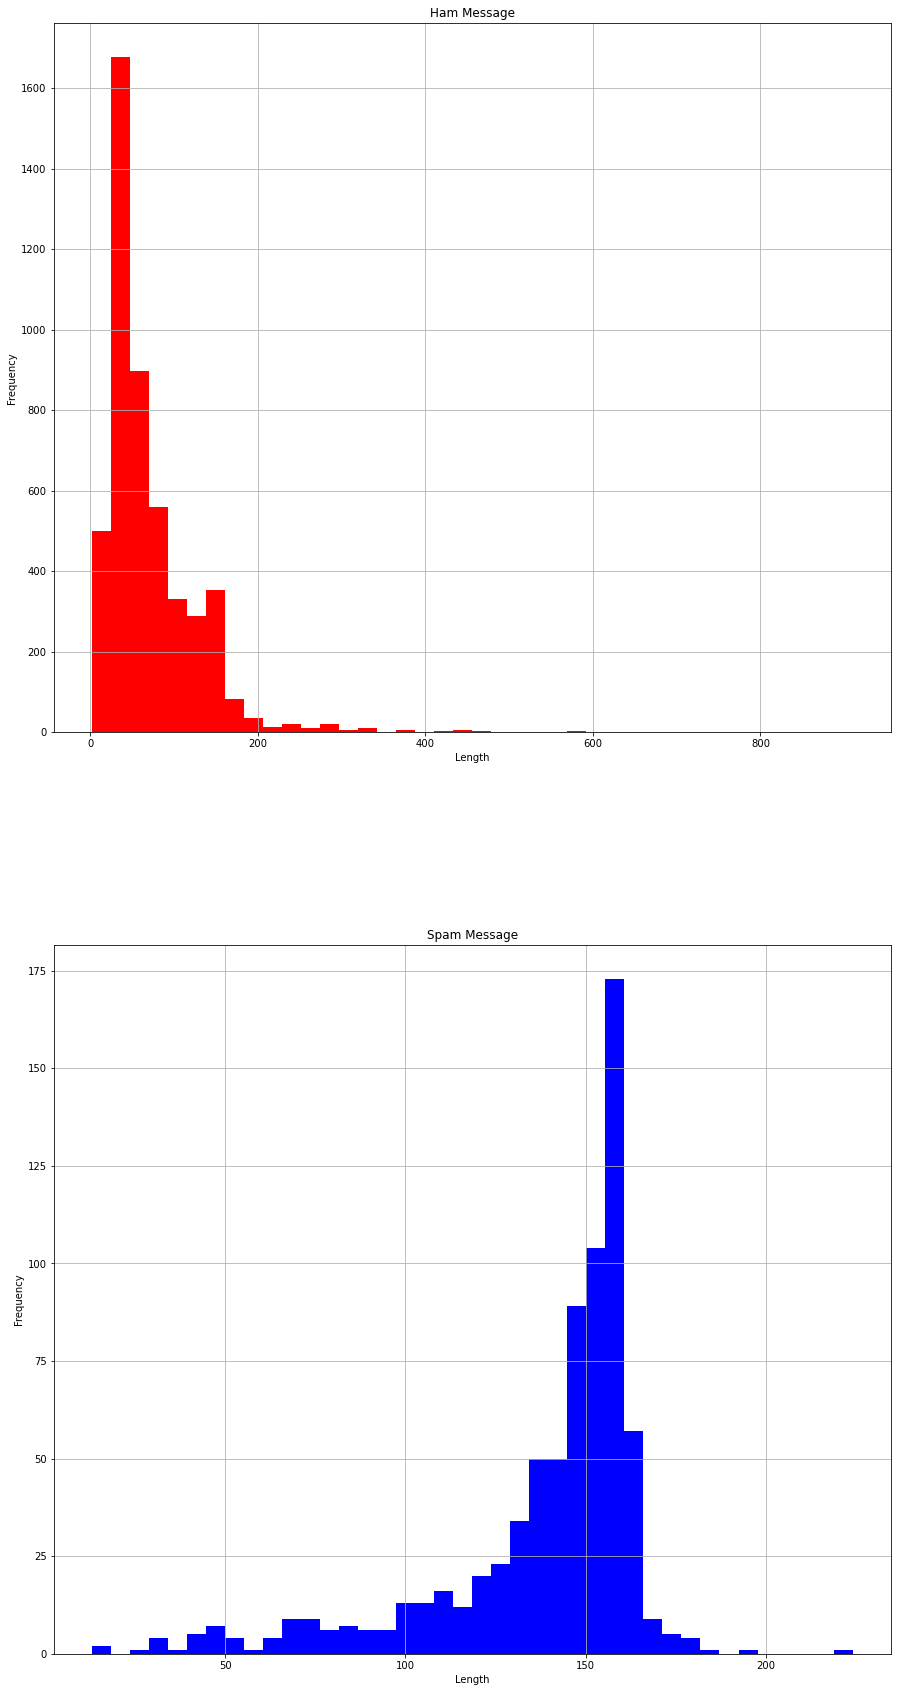

In [16]:
fig, ax = plt.subplots(2,figsize=(15, 30))
sms[sms['label']=='ham'].hist(column='length', bins=40,ax=ax[0],color = 'red')
ax[0].set(xlabel = 'Length',ylabel = 'Frequency',title = 'Ham Message')
sms[sms['label']=='spam'].hist(column='length', bins=40,ax=ax[1],color = 'blue')
ax[1].set(xlabel = 'Length',ylabel = 'Frequency',title = 'Spam Message')

## 3.2 WordClouds

In [17]:
#separate the label
sms_ham = sms[sms['label'] == 'ham']
sms_spam = sms[sms['label'] == 'spam']

### 3.2.1 WordCloud for Ham Messages

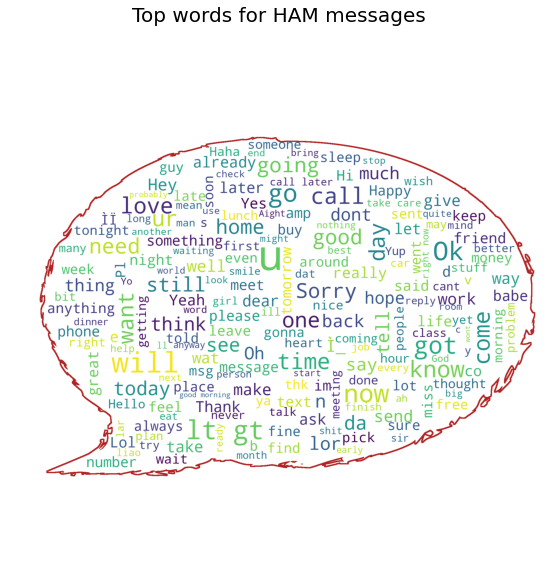

In [18]:
message_mask = np.array(Image.open('message_mask.png'))
sw = set(STOPWORDS)
wc = WordCloud(
    stopwords=sw,
    background_color='white', 
    max_words=200, 
    mask=message_mask,
    contour_width=3, 
    contour_color='firebrick'
)
text = ' '.join(sms_ham['message'].astype(str).tolist())
wc.generate(text)
plt.figure(figsize=(20,10))
plt.title('Top words for HAM messages',fontsize=20)
plt.imshow(wc)
plt.axis("off")
plt.show()

### 3.2.2 WordCloud for Spam Messages

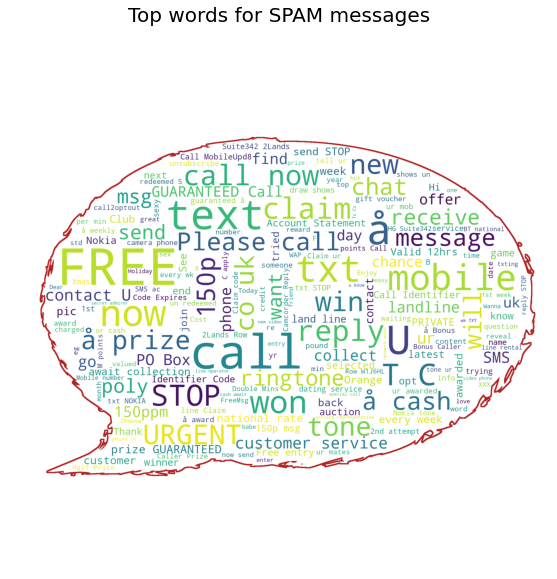

In [19]:
message_mask = np.array(Image.open('message_mask.png'))
sw = set(STOPWORDS)
wc = WordCloud(
    stopwords=sw,
    background_color='white', 
    max_words=200, 
    mask=message_mask,
    contour_width=3, 
    contour_color='firebrick'
)
text = ' '.join(sms_spam['message'].astype(str).tolist())
wc.generate(text)
plt.figure(figsize=(20,10))
plt.title('Top words for SPAM messages',fontsize=20)
plt.imshow(wc)
plt.axis("off")
plt.show()

# 4.0 Text Preprocessing


## 4.1 Data Cleaning
Do some cleaning to the text data:
- Remove all punctuation
- Remove all stopwords
- Convert text to lower case
- Stemming

In [20]:
def txt_preprocess(text):
    
    stpword = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    #check if there are any punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    #join the characters
    nopunc = ''.join(nopunc)
    
    #remove any stopwords and convert to lower case
    clean_stopwords = [word for word in nopunc.split() if word.lower() not in stpword]
    
    clean_words = ""
    
    #stemming
    for x in clean_stopwords:
        stemmer = SnowballStemmer("english")
        clean_words += (stemmer.stem(x)) + " "
    
    return clean_words

In [21]:
sms['clean_message'] = sms['message'].apply(txt_preprocess)

In [22]:
sms.head()

,label,message,label_num,length,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entri wkli comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say earli hor c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think goe usf live around though


## 4.2 Vectorization

In [23]:
X = sms['clean_message']
y = sms['label_num']

In [24]:
#Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457,)
(1115,)
(4457,)
(1115,)


In [25]:
#vectorizer
vect = CountVectorizer()
# learn training data vocabulary
vect.fit(X_train)

CountVectorizer()

In [26]:
# transform training data into a document-term matrix
X_train_dtm = vect.transform(X_train)
X_train_dtm

<4457x7124 sparse matrix of type '<class 'numpy.int64'>'
	with 36911 stored elements in Compressed Sparse Row format>

In [27]:
# transform testing data into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1115x7124 sparse matrix of type '<class 'numpy.int64'>'
	with 8120 stored elements in Compressed Sparse Row format>

In [28]:
# Using term frequency-inverse document frequency to evaluate the importance of a word is to a document in a collection or corpus
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

# 5.0 Building Predictive Model

Different classifier has been used to find out the best classifier for spam message classification

In [29]:
#list for storing accuracy score of different classifier
acc_score =[]

## 5.1 AdaBoost Classifier

In [30]:
#instantiate a AdaBoost Classifier model
abc = AdaBoostClassifier()

In [31]:
abc.fit(X_train_dtm, y_train)

AdaBoostClassifier()

In [32]:
abc_pred = abc.predict(X_test_dtm)

In [33]:
#calculate the accuracy score and AUC for this model
abc_score = accuracy_score(y_test, abc_pred)
print(abc_score)
acc_score.append(abc_score)

0.9713004484304932


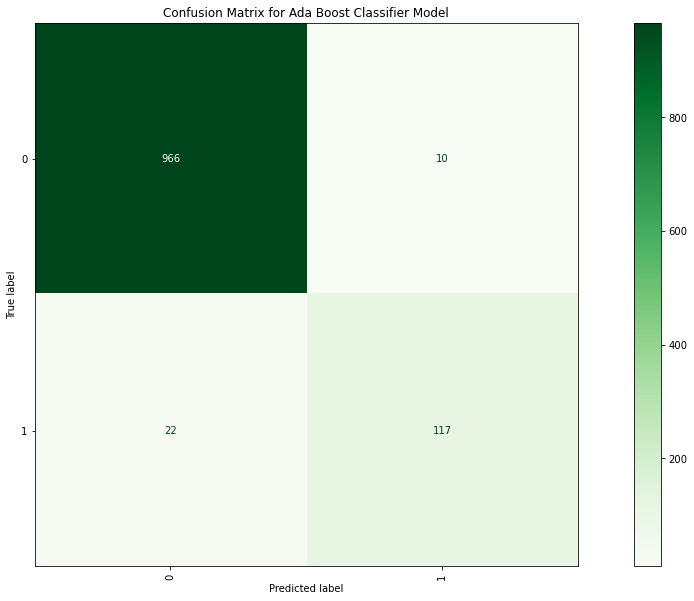

In [34]:
#display the confusion matrix
fig1,ax1 = plt.subplots(figsize = (20,10))
ax1.set_title("Confusion Matrix for Ada Boost Classifier Model")
abc_conf_matrix = confusion_matrix(y_test, abc_pred)
abc_display = ConfusionMatrixDisplay(confusion_matrix=abc_conf_matrix,display_labels = abc.classes_)
abc_display.plot(cmap = 'Greens',xticks_rotation ='vertical',ax=ax1)

## 5.2 Multinomial Naive Bayes Classifier

In [35]:
#instantiate a Multinomial Naive Bayes Classifier
nb = MultinomialNB()

In [36]:
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [37]:
nb_pred = nb.predict(X_test_dtm)

In [38]:
#calculate the accuracy score and AUC for this model
nb_score = accuracy_score(y_test, nb_pred)
print(nb_score)
acc_score.append(nb_score)

0.9856502242152466


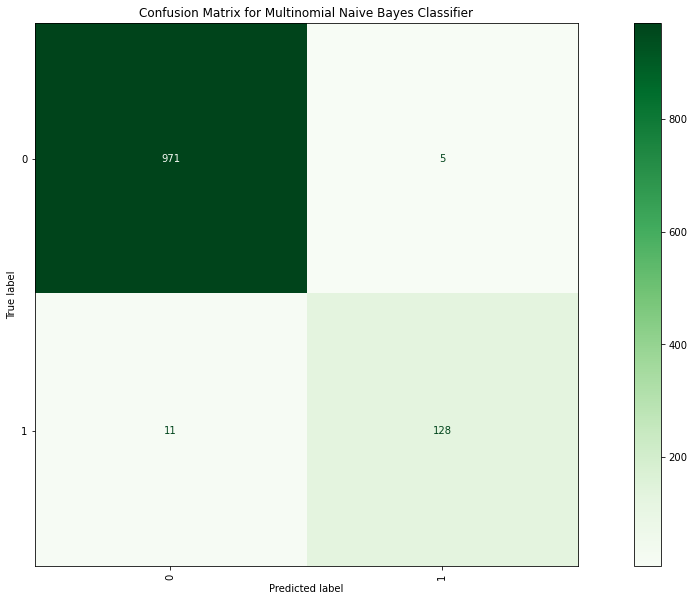

In [39]:
#display the confusion matrix
fig1,ax1 = plt.subplots(figsize = (20,10))
ax1.set_title("Confusion Matrix for Multinomial Naive Bayes Classifier")
nb_conf_matrix = confusion_matrix(y_test, nb_pred)
nb_display = ConfusionMatrixDisplay(confusion_matrix=nb_conf_matrix,display_labels = nb.classes_)
nb_display.plot(cmap = 'Greens',xticks_rotation ='vertical',ax=ax1)

## 5.3 Logistic Regression

In [40]:
#instantiate a Logistic Regression
lr = LogisticRegression(solver='liblinear')

In [41]:
lr.fit(X_train_dtm, y_train)

LogisticRegression(solver='liblinear')

In [42]:
lr_pred = lr.predict(X_test_dtm)

In [43]:
#calculate the accuracy score and AUC for this model
lr_score = accuracy_score(y_test, lr_pred)
print(lr_score)
acc_score.append(lr_score)

0.9874439461883409


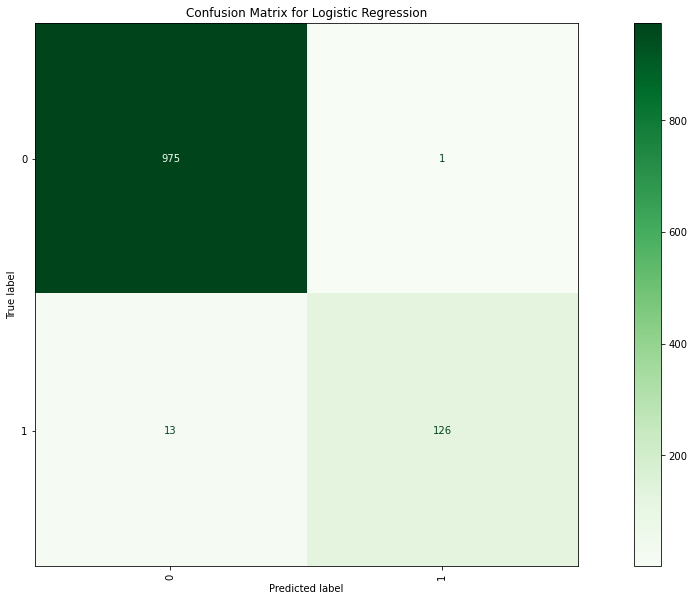

In [44]:
#display the confusion matrix
fig1,ax1 = plt.subplots(figsize = (20,10))
ax1.set_title("Confusion Matrix for Logistic Regression")
lr_conf_matrix = confusion_matrix(y_test, lr_pred)
lr_display = ConfusionMatrixDisplay(confusion_matrix=lr_conf_matrix,display_labels = lr.classes_)
lr_display.plot(cmap = 'Greens',xticks_rotation ='vertical',ax=ax1)

## 5.4 K-Nearest Neighbors Classifier

In [45]:
#instantiate a KNN Classifier
knc = KNeighborsClassifier()

In [46]:
knc.fit(X_train_dtm, y_train)

KNeighborsClassifier()

In [47]:
knc_pred = knc.predict(X_test_dtm)

In [48]:
#calculate the accuracy score and AUC for this model
knc_score = accuracy_score(y_test, knc_pred)
print(knc_score)
acc_score.append(knc_score)

0.9255605381165919


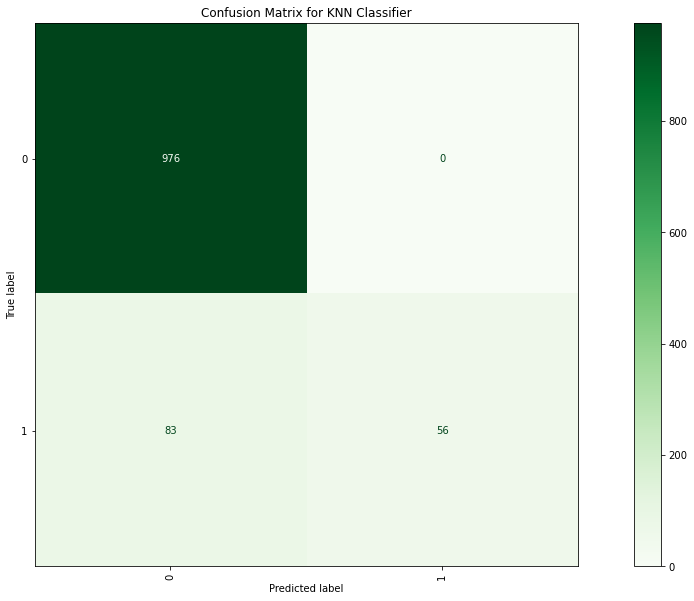

In [49]:
#display the confusion matrix
fig1,ax1 = plt.subplots(figsize = (20,10))
ax1.set_title("Confusion Matrix for KNN Classifier")
knc_conf_matrix = confusion_matrix(y_test, knc_pred)
knc_display = ConfusionMatrixDisplay(confusion_matrix=knc_conf_matrix,display_labels = knc.classes_)
knc_display.plot(cmap = 'Greens',xticks_rotation ='vertical',ax=ax1)

## 5.5 Bagging Classifier

In [50]:
#instantiate a Bagging Classifier
bc = BaggingClassifier()

In [51]:
bc.fit(X_train_dtm, y_train)

BaggingClassifier()

In [52]:
bc_pred = bc.predict(X_test_dtm)

In [53]:
#calculate the accuracy score and AUC for this model
bc_score = accuracy_score(y_test, bc_pred)
print(bc_score)
acc_score.append(bc_score)

0.9713004484304932


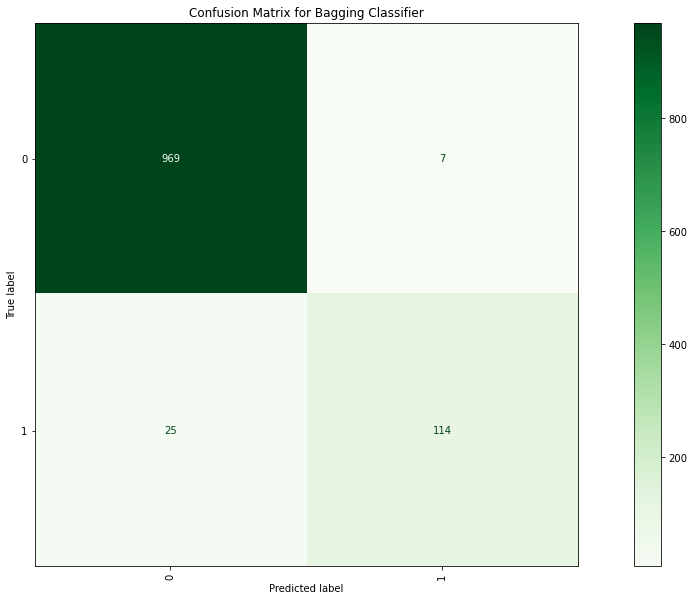

In [54]:
#display the confusion matrix
fig1,ax1 = plt.subplots(figsize = (20,10))
ax1.set_title("Confusion Matrix for Bagging Classifier")
bc_conf_matrix = confusion_matrix(y_test, bc_pred)
bc_display = ConfusionMatrixDisplay(confusion_matrix=bc_conf_matrix,display_labels = bc.classes_)
bc_display.plot(cmap = 'Greens',xticks_rotation ='vertical',ax=ax1)

## 5.6 Gradient Boosting Classifier

In [55]:
#instantiate a Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

In [56]:
gbc.fit(X_train_dtm, y_train)

GradientBoostingClassifier()

In [57]:
gbc_pred = gbc.predict(X_test_dtm)

In [58]:
#calculate the accuracy score and AUC for this model
gbc_score = accuracy_score(y_test, gbc_pred)
print(gbc_score)
acc_score.append(gbc_score)

0.9757847533632287


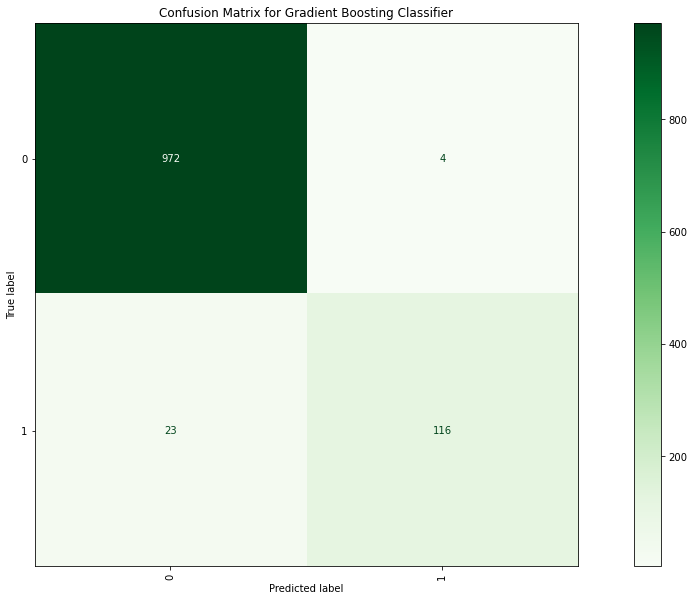

In [59]:
#display the confusion matrix
fig1,ax1 = plt.subplots(figsize = (20,10))
ax1.set_title("Confusion Matrix for Gradient Boosting Classifier")
gbc_conf_matrix = confusion_matrix(y_test, gbc_pred)
gbc_display = ConfusionMatrixDisplay(confusion_matrix=gbc_conf_matrix,display_labels = gbc.classes_)
gbc_display.plot(cmap = 'Greens',xticks_rotation ='vertical',ax=ax1)

# 6.0 Comparing Model

## 6.1 Accuracy Score

In [60]:
#comparing the accuracy score
model_name=['AdaBoost Classifier','Naive Bayes Classifier','Logistic Regression','KNN Classifier ','Bagging Classifier','Gradient Boosting']
acc_score=np.array(acc_score)
for x in range(len(model_name)): 
    print(model_name[x],"\t\t\t",acc_score[x]) 

AdaBoost Classifier 			 0.9713004484304932
Naive Bayes Classifier 			 0.9856502242152466
Logistic Regression 			 0.9874439461883409
KNN Classifier  			 0.9255605381165919
Bagging Classifier 			 0.9713004484304932
Gradient Boosting 			 0.9757847533632287


Text(0, 0.5, 'Accuracy Score')

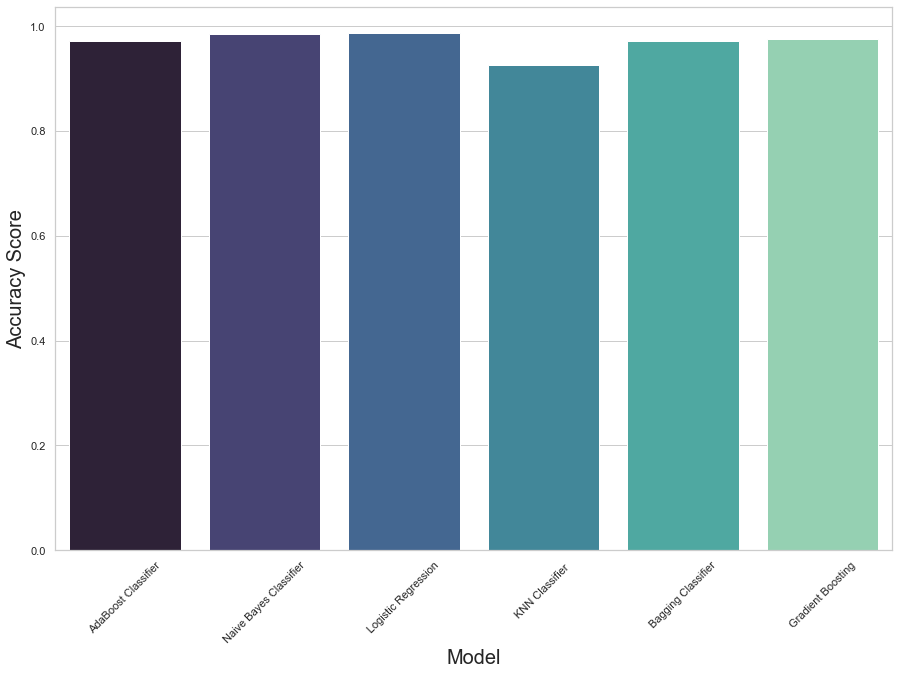

In [61]:
#plotting
plt.figure(figsize=(15,10))
sns.set_theme(style="whitegrid")
sns.barplot(y=acc_score,x=model_name,palette = "mako")
plt.xlabel('Model',size=20)
plt.xticks(rotation=45)
plt.ylabel('Accuracy Score',size=20)

From the plot above, it is shown that Logistic Regression has the highest accuracy.

## 6.2 ROC Curve

In [62]:
#predict probability
pred_prob1 = abc.predict_proba(X_test_dtm)[:,1]
pred_prob2 = nb.predict_proba(X_test_dtm)[:,1]
pred_prob3 = lr.predict_proba(X_test_dtm)[:,1]
pred_prob4 = knc.predict_proba(X_test_dtm)[:,1]
pred_prob5 = bc.predict_proba(X_test_dtm)[:,1]
pred_prob6 = gbc.predict_proba(X_test_dtm)[:,1]

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2, pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3, pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4, pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5, pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob6, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

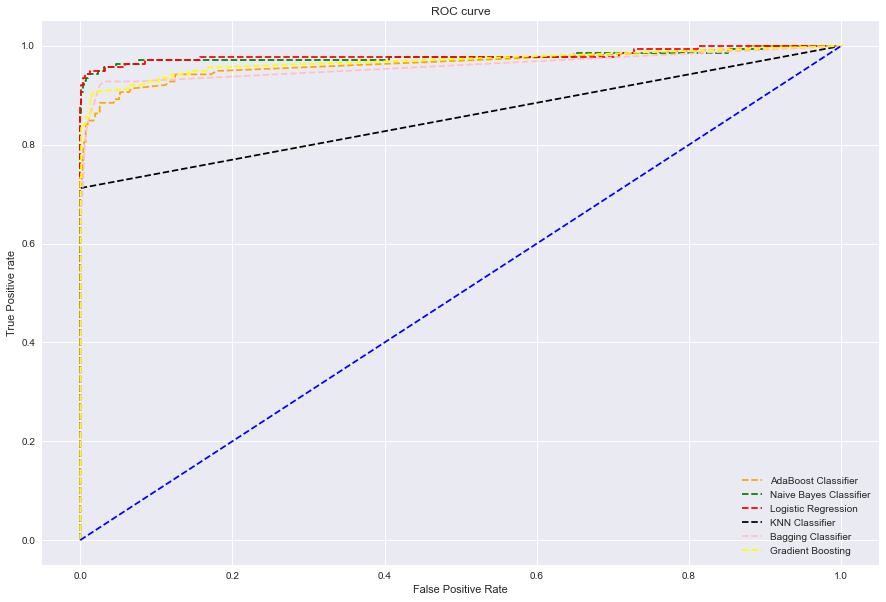

In [63]:
# matplotlib
plt.style.use('seaborn')
plt.figure(figsize=(15,10))
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='AdaBoost Classifier')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Naive Bayes Classifier')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Logistic Regression')
plt.plot(fpr4, tpr4, linestyle='--',color='black', label='KNN Classifier')
plt.plot(fpr5, tpr5, linestyle='--',color='pink', label='Bagging Classifier')
plt.plot(fpr6, tpr6, linestyle='--',color='yellow', label='Gradient Boosting')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [64]:
print("ROC AUC score:")
print("AdaBoost Classifier \t\t", roc_auc_score(y_test, pred_prob1))
print("Naive Bayes Classifier \t\t", roc_auc_score(y_test, pred_prob2))
print("Logistic Regression \t\t", roc_auc_score(y_test, pred_prob3))
print("KNN Classifier \t\t\t", roc_auc_score(y_test, pred_prob4))
print("Bagging Classifier\t\t", roc_auc_score(y_test, pred_prob5))
print("Gradient Boosting \t\t", roc_auc_score(y_test, pred_prob6))

ROC AUC score:
AdaBoost Classifier 		 0.9638592404764714
Naive Bayes Classifier 		 0.9782772142941385
Logistic Regression 		 0.9811888194362544
KNN Classifier 			 0.8561151079136691
Bagging Classifier		 0.9586883771671189
Gradient Boosting 		 0.968679974053544


It is shown that AUC for Logistic Regression ROC curve is the highest among all the models. Logistic Regression has the highest true positive rate. Therefore, we can say that Logistic Regression did a better job of classifying the positive class in the dataset.

# 7.0 Conclusion

Logistic Regression has the highest accuracy score and AUC-ROC among all the 6 models. It obtained an __accuracy score__ of 0.9874 and __AUC-ROC__ of 0.98. It is proved that Logistic Regression can be used to accurately classify which texts are spam.

In the future, fine-tuning of Logistic Regression will be carried out in order to improve the accuracy score and AUC-ROC of the model. Since Logistic Regression is able to detect spam messages accurately in this dataset, this model may be used for text classification for other aspects.